In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import math
from utils.rotate_crop import crop_rotated_rectangle, inside_rect, vis_rotcrop
import torchvision.transforms.functional as tf
import PIL
import glob, os, pickle
import torch
import re
import os
from tqdm import tqdm
import mediapipe as mp



In [18]:
os.environ['PATH'] += os.pathsep + '/usr/bin/ffprobe'

#mtcnn = MTCNN(select_largest=False, device='cuda', image_size=224, margin=0)
# resnet = InceptionResnetV1(pretrained='vggface2').eval().cuda()
import ffmpeg

output_folder = 'preposess'


In [19]:
def check_rotation(path_video_file):

    # this returns meta-data of the video file in form of a dictionary
    meta_dict = ffmpeg.probe(path_video_file)

    # from the dictionary, meta_dict['streams'][0]['tags']['rotate'] is the key
    # we are looking for
    rotateCode = None

    if 'tags' in meta_dict['streams'][0] and 'rotate' in meta_dict['streams'][0]['tags']:
        if int(meta_dict['streams'][0]['tags']['rotate']) == 90:
            rotateCode = cv2.ROTATE_90_CLOCKWISE
        elif int(meta_dict['streams'][0]['tags']['rotate']) == 180:
            rotateCode = cv2.ROTATE_180
        elif int(meta_dict['streams'][0]['tags']['rotate']) == 270:
            rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE
        return rotateCode
    else:
        return -1


def proposess_video(video_path, savepath, sample_ratio=5, max=1000):

    v_cap = cv2.VideoCapture(video_path)

    rotateCode = check_rotation(video_path)

    frame_id = 0
    while True:
        success, frame = v_cap.read()
        if not success:
            break
        if frame_id > max:
            break
        if frame_id % sample_ratio == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if rotateCode > -1:
                frame = cv2.rotate(frame, rotateCode)

            # Detect face
#             batch_boxes, batch_probs, batch_points = mtcnn.detect(frame, landmarks=True)
#             if batch_boxes is None:
#                 continue
#             cropped_tsn = mtcnn.extract(frame, batch_boxes, None)
#             if cropped_tsn is None:
#                 continue
            #img_embedding = resnet(cropped_tsn.cuda().unsqueeze(0))
#             img_embedding = None
#             prob = batch_probs[0]
#             box = batch_boxes[0].astype(int)
#             points = batch_points[0].astype(int)
#             box = np.maximum(box, 0)
#             points = np.maximum(points, 0)
#             cropped = frame[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
#             cropped = cropped.astype("uint8")                

            plt.imsave(os.path.join(savepath, f'org_{frame_id:04d}.jpg'), frame)
            #plt.imsave(os.path.join(savepath, f'crop_{frame_id:04d}.jpg'), cropped)
#             info_dict = {
#                 'box': box,
#                 'detect_prob': prob,
#                 'points': points,
#                 'face_embed': None,
#                 'frame_id': frame_id
#             }
#             info_dict = {
#                 'box': box,
#                 'detect_prob': prob,
#                 'points': points,
#                 'face_embed': img_embedding.data.cpu().numpy(),
#                 'frame_id': frame_id
#             }
#             np.save(os.path.join(savepath, f'infov1_{frame_id:04d}.npy'), info_dict, allow_pickle=True)
        frame_id += 1

def proposess_imglist(imglist, savepath):

    for i, img in enumerate(imglist):
        frame_id = i * 5
        frame = imread(img)
        # Detect face
        try:
            batch_boxes, batch_probs, batch_points = mtcnn.detect(frame, landmarks=True)
        except RuntimeError:
            print(f"error in handling {img}")
            continue
        if batch_boxes is None:
            continue
        cropped_tsn = mtcnn.extract(frame, batch_boxes, None)
        if cropped_tsn is None:
            continue
        img_embedding = resnet(cropped_tsn.cuda().unsqueeze(0))

        prob = batch_probs[0]
        box = batch_boxes[0].astype(int)
        points = batch_points[0].astype(int)
        box = np.maximum(box, 0)
        points = np.maximum(points, 0)
        cropped = frame[int(box[1]):int(box[3]), int(box[0]):int(box[2])]

        plt.imsave(os.path.join(savepath, f'org_{frame_id:04d}.jpg'), frame)
        plt.imsave(os.path.join(savepath, f'crop_{frame_id:04d}.jpg'), Image.fromarray(cropped))
#         info_dict = {
#             'box': box,
#             'detect_prob': prob,
#             'points': points,
#             'face_embed': img_embedding.data.cpu().numpy(),
#             'frame_id': frame_id
#         }
        info_dict = {
            'box': box,
            'detect_prob': prob,
            'points': points,
            'face_embed': None,
            'frame_id': frame_id
        }
        np.save(os.path.join(savepath, f'infov1_{frame_id:04d}.npy'), info_dict, allow_pickle=True)


def run_replay(rootpath):
    outpath = os.path.join(rootpath, output_folder)
    os.makedirs(outpath, exist_ok=True)

    file_list = glob.glob(rootpath + "**/*.mov", recursive=True)
    meta_info_list = []

    savepaths = []
    for i, filepath in enumerate(file_list):

        video_prefix = "_".join(filepath.split("/")[-2:]).split('.')[0]

        if "/real/" in filepath:
            live_or_spoof = 'live'
        elif "/attack/" in filepath:
            live_or_spoof = 'spoof'
        else:
            raise RuntimeError(f"What is wrong? {filepath}")

        if "/train/" in filepath:
            split = 'train'
        elif "/test/" in filepath:
            split = 'test'
        elif "/devel/" in filepath:
            split = 'dev'
        elif "/enroll/" in filepath:
            split = 'enroll'
        else:
            raise RuntimeError(f"What is wrong? {filepath}")

        name = f"replay_{split}_{live_or_spoof}_{video_prefix}"
        savepath = os.path.join(outpath, name)

        if os.path.exists(savepath) and len(os.listdir(savepath)) > 10:
            savepaths.append(savepath)
            # print(i, f"skip {savepath}")
            continue
        else:
            os.makedirs(savepath, exist_ok=True)
            print(f"make {savepath}")

        proposess_video(filepath, savepath)
        if i % 20 == 0:
            print(f"processed {i} / {len(file_list)}")

        meta_info_list.append((name, live_or_spoof, split))

    return meta_info_list


def run_msu(rootpath):
    outpath = os.path.join(rootpath, output_folder)
    os.makedirs(outpath, exist_ok=True)
    meta_info_list = []

    file_list = glob.glob(rootpath + "**/*.mov", recursive=True)
    file_list += glob.glob(rootpath + "**/*.mp4", recursive=True)

    test_list = np.loadtxt(os.path.join(rootpath, 'test_sub_list.txt')).astype(int)
    train_list = np.loadtxt(os.path.join(rootpath, 'train_sub_list.txt')).astype(int)

    for i, filepath in enumerate(file_list):

        video_prefix = filepath.split("/")[-1].split('.')[0]

        if "/real/" in filepath:
            live_or_spoof = 'live'
        elif "/attack/" in filepath:
            live_or_spoof = 'spoof'
        else:
            raise RuntimeError(f"What is wrong? {filepath}")

        id = int(re.search("client(\d\d\d)", filepath).group(1))

        if id in train_list:
            split = 'train'
        elif id in test_list:
            split = 'test'
        else:
            split = 'dev'

        name = f"replay_{split}_{live_or_spoof}_{video_prefix}"
        savepath = os.path.join(outpath, name)

        if os.path.exists(savepath) and len(os.listdir(savepath)) > 10:
            continue
        else:
            os.makedirs(savepath, exist_ok=True)
            print(f"make {savepath}")

        proposess_video(filepath, savepath)
        if i % 20 == 0:
            print(f"processed {i} / {len(file_list)}")

        meta_info_list.append((name, live_or_spoof, split))


def run_oulu(rootpath):
    outpath = os.path.join(rootpath, output_folder)
    os.makedirs(outpath, exist_ok=True)

    file_list = glob.glob(rootpath + "**/*.avi", recursive=True)
    meta_info_list = []

    for i, filepath in enumerate(file_list):

        video_prefix = filepath.split("/")[-1].split('.')[0]

        if "1.avi" in filepath:
            live_or_spoof = 'live'
        else:
            live_or_spoof = 'spoof'

        if "/Train_files/" in filepath:
            split = 'train'
        elif "/Test_files/" in filepath:
            split = 'test'
        elif "/Dev_files/" in filepath:
            split = 'dev'
        else:
            raise RuntimeError(f"What is wrong? {filepath}")

        name = f"oulu_{split}_{live_or_spoof}_{video_prefix}"
        savepath = os.path.join(outpath, name)
        if os.path.exists(savepath) and len(os.listdir(savepath)) > 10:
            continue
        else:
            os.makedirs(savepath, exist_ok=True)
            print(f"make {savepath}")

        proposess_video(filepath, savepath)
        if i % 20 == 0:
            print(f"processed {i} / {len(file_list)}")

        meta_info_list.append((name, live_or_spoof, split))

    return meta_info_list

def run_casia(rootpath):
    outpath = os.path.join(rootpath, output_folder)
    os.makedirs(outpath, exist_ok=True)

    file_list = glob.glob(rootpath + "**/*.avi", recursive=True)
    meta_info_list = []

    for i, filepath in enumerate(file_list):

        tokens = filepath.split("/")[-2:]
        if 'HR_' not in tokens[-1]:
            tokens[-1] = 'NM_' + tokens[-1]

        video_prefix = "_".join(tokens).split('.')[0]

        if "/1.avi" in filepath or "/2.avi" in filepath or "/HR_1.avi" in filepath:
            live_or_spoof = 'live'
        else:
            live_or_spoof = 'spoof'

        if "/train_release/" in filepath:
            split = 'train'
        elif "/test_release/" in filepath:
            split = 'test'
        else:
            raise RuntimeError(f"What is wrong? {filepath}")

        name = f"casia_{split}_{live_or_spoof}_{video_prefix}"
        savepath = os.path.join(outpath, name)
        if os.path.exists(savepath) and len(os.listdir(savepath)) > 10:
            continue
        else:
            os.makedirs(savepath, exist_ok=True)
            print(f"make {savepath}")

        proposess_video(filepath, savepath)

        if i % 20 == 0:
            print(f"processed {i} / {len(file_list)}")

        meta_info_list.append((name, live_or_spoof, split))

    return meta_info_list


def run_celeba(rootpath, saveroot):
    outpath = os.path.join(saveroot, 'preposess')
    os.makedirs(outpath, exist_ok=True)

    for split in ['train', 'test']:
        path_split = os.path.join(rootpath, split)
        for id in os.listdir(path_split):
            path_split_id = os.path.join(path_split, id)
            for live_or_spoof in ['live', 'spoof']:
                path_split_id_label = os.path.join(path_split_id, live_or_spoof)
                if os.path.exists(path_split_id_label):
                    img_file_list = glob.glob(path_split_id_label + "/*.jpg", recursive=False) + \
                                    glob.glob(path_split_id_label + "/*.png", recursive=False)

                    name = f"celeba_{split}_{live_or_spoof}_{id}"
                    savepath = os.path.join(outpath, name)


                    if os.path.exists(savepath) and len(os.listdir(savepath)) > 4:
                        print(f"skip {savepath}")
                        continue
                    else:
                        os.makedirs(savepath, exist_ok=True)
                        print(f"make {savepath}")

                    proposess_imglist(img_file_list, savepath)


def generate_square_images(image, info, face_width=400, range_scale=3):
    points = np.array(info['points'])
    dist = lambda p1, p2: int(np.sqrt(((p1 - p2) ** 2).sum()))
    width = dist(points[0], points[1])
    # height = max(dist(points[1], points[4]), dist(points[0], points[3]))
    center = tuple(points[2])

    angle = math.degrees(math.atan((points[1, 1] - points[0, 1]) / (points[1, 0] - points[0, 0])))
    rect = (center, (int(width * range_scale), int(width * range_scale)), angle)
    img_rows = image.shape[0]
    img_cols = image.shape[1]

    round = 0
    initial_scale = range_scale
    scale = range_scale
    min_scale = (256 / face_width) * initial_scale + 0.2

    while True:
        if inside_rect(rect=rect, num_cols=img_cols, num_rows=img_rows):
            break

        if scale < min_scale:
            pad_size = 3000
            image = np.array(tf.pad(PIL.Image.fromarray(image), pad_size, padding_mode='symmetric'))
            center = (center[0] + pad_size, center[1] + pad_size)
            rect = (center, (int(width * scale), int(width * scale)), angle)
            break

        scale = range_scale - round * 0.1
        rect = (center, (int(width * scale), int(width * scale)), angle)
        round += 1


    scaled_face_size = int(face_width * scale / initial_scale)
    image_square_cropped = crop_rotated_rectangle(image=image, rect=rect)
    # vis_rotcrop(image, image_square_cropped, rect, center)
    image_resized = cv2.resize(image_square_cropped, (scaled_face_size, scaled_face_size))
    return image_resized

def generate_square_crop(rootpath, face_width=400):
    files = os.listdir(rootpath)
    for i, file in enumerate(files):
        print(i, file)
        video_clip_path = os.path.join(rootpath, file)
        frames_total = len(glob.glob(os.path.join(video_clip_path, "*.jpg")))

        for image_id in range(frames_total):
            image_name = f"org_{image_id * 5:04d}.jpg"

            # image_name = f"crop_{image_id*5:04d}.jpg"
            info_name = f"infov1_{image_id * 5:04d}.npy"
            # image_name = "{}_{}_scene.jpg".format(video_name, image_id)
            image_path = os.path.join(video_clip_path, image_name)
            info_path = os.path.join(video_clip_path, info_name)

            if not (os.path.exists(image_path) and os.path.exists(info_path)):
                continue
            try:
                info = np.load(info_path, allow_pickle=True).item()
            except pickle.UnpicklingError:
                print(f"*** error with {video_clip_path}")
                break
            square_image_path = os.path.join(video_clip_path, f"square{face_width}_{image_id * 5:04d}.jpg")
            if not os.path.exists(square_image_path):
                image = imread(image_path)
                
                square_image = generate_square_images(image, info, face_width=face_width)
                plt.imsave(square_image_path, square_image)


In [4]:
oulu_info = run_oulu(rootpath="/media/hassan-hossein/B660FEE360FEA8EF/oulu/")

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_2_2_22_1
processed 0 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_3_23_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_1_24_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_1_1_21_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_1_21_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_1_21_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_1_21_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_1_21_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_1_1_22_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_1_22_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_1_22_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spo

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_1_2_26_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_2_26_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_2_26_3
processed 100 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_2_26_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_2_26_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_1_2_27_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_2_27_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_1_24_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_1_1_28_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_1_31_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_1_35_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_s

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_3_28_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_3_28_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_3_28_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_1_3_29_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_3_29_2
processed 200 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_3_29_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_3_29_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_3_29_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_1_3_30_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_3_30_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_1_3_30_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_2_1_34_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_2_1_34_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_2_1_34_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_2_1_34_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_2_1_35_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_2_1_35_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_2_1_35_3
processed 300 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_2_1_35_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_2_1_35_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_2_2_21_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_2_2_21_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_2_3_24_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_2_3_25_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_2_3_25_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_2_3_25_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_2_3_25_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_2_3_26_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_2_3_26_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_2_3_26_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_2_3_26_4
processed 400 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_2_3_26_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_2_3_27_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_1_30_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_1_30_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_3_1_31_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_1_31_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_1_31_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_1_31_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_3_1_32_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_1_32_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_1_32_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_1_32_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_1_32_5
processed 500 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_3_21_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_3_21_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_3_21_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_3_3_22_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_3_22_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_3_22_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_3_22_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_3_22_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_3_3_23_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_3_23_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_3_23_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_3_23_5
make /

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_1_23_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_4_1_24_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_1_24_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_1_24_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_1_24_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_1_24_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_4_1_25_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_1_25_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_1_25_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_1_25_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_1_25_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_4_1_26_1
make /m

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_2_29_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_2_29_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_4_2_30_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_2_30_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_2_30_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_2_30_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_2_30_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_4_2_31_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_2_31_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_2_31_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_2_31_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_2_31_5
make /

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_3_35_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_3_35_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_4_3_35_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_5_1_21_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_1_21_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_1_21_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_1_21_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_1_21_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_5_1_22_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_1_22_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_1_22_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_1_22_4
make /

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_2_22_4
processed 980 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_2_22_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_5_2_23_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_2_23_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_2_23_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_2_23_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_5_2_24_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_2_24_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_2_24_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_2_24_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_2_24_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_3_28_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_3_28_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_3_28_5
processed 1080 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_5_3_29_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_3_29_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_3_29_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_3_29_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_3_29_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_5_3_30_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_3_30_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_5_3_30_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_6_1_34_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_6_1_34_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_6_1_34_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_6_1_34_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_6_1_35_1
processed 1180 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_6_1_35_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_6_1_35_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_6_1_35_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_6_1_35_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_6_2_21_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_6_2_21_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_6_2_35_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_6_2_35_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_6_2_35_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_6_2_35_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_6_2_35_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_6_3_21_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_6_3_21_2
processed 1280 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_6_3_21_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_6_3_21_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_6_3_22_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_6_3_22_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_1_40_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_1_40_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_1_1_41_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_1_41_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_1_41_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_1_41_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_1_41_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_1_1_42_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_1_42_2
processed 1380 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_1_42_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_1_42_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/prepose

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_2_37_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_1_2_38_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_2_38_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_2_38_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_2_38_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_2_38_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_1_2_39_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_2_39_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_2_39_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_2_39_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_2_39_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_1_2_

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_3_38_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_3_38_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_3_38_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_3_38_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_3_39_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_3_39_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_3_39_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_3_39_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_1_3_40_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_3_40_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_3_40_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_1_

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_1_38_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_2_1_39_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_1_39_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_1_39_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_1_39_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_1_39_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_2_1_40_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_1_40_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_1_40_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_1_40_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_2_1_41_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_1_

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_2_39_3
processed 1760 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_2_39_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_2_39_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_2_2_40_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_2_40_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_2_40_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_2_40_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_2_40_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_2_2_41_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_2_41_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_2_41_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/prepose

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_3_39_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_2_3_40_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_3_40_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_3_40_4
processed 1860 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_3_40_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_2_3_41_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_3_41_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_3_41_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_3_41_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_3_41_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_2_3_42_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposes

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_1_40_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_1_40_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_1_40_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_3_1_41_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_1_41_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_1_41_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_1_41_4
processed 1960 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_1_40_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_1_44_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_1_47_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_2_1_51_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/prepos

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_2_37_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_2_37_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_3_2_38_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_2_38_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_2_38_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_2_38_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_2_38_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_3_2_39_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_2_39_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_2_39_3
processed 2060 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_2_39_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/prepose

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_3_38_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_3_38_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_3_38_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_3_38_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_3_3_39_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_3_39_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_3_39_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_3_39_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_3_39_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_3_3_40_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_3_40_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_3_3

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_1_38_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_1_38_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_4_1_39_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_1_39_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_1_39_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_1_39_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_4_1_40_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_1_40_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_1_40_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_1_40_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_1_40_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_4_1_

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_1_55_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_4_2_36_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_2_36_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_2_36_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_2_36_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_2_36_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_4_2_37_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_2_37_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_2_37_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_2_37_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_4_2_38_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_2_

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_3_36_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_3_36_4
processed 2440 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_3_36_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_4_3_37_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_3_37_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_3_37_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_3_37_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_3_37_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_4_3_38_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_3_38_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_4_3_38_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/prepose

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_1_36_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_1_37_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_1_37_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_1_37_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_1_37_5
processed 2540 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_5_1_38_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_1_38_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_1_38_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_1_38_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_1_38_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_5_1_39_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/prepose

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_5_1_54_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_1_54_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_1_54_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_1_54_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_1_54_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_1_55_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_1_55_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_1_55_4
processed 2640 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_1_55_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_5_2_36_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_2_36_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/prepose

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_2_54_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_2_54_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_5_2_55_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_2_55_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_2_55_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_2_55_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_2_55_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_5_3_36_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_3_36_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_3_36_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_3_36_5
processed 2740 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/prepose

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_3_55_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_3_55_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_3_55_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_5_3_55_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_6_1_36_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_1_36_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_1_36_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_1_36_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_1_36_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_6_1_37_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_1_37_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_1

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_1_48_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_1_48_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_1_48_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_1_48_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_1_49_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_1_49_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_1_49_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_1_49_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_6_1_50_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_1_50_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_1_50_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_

processed 3020 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_2_48_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_6_2_49_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_2_49_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_2_49_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_2_49_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_2_49_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_6_2_50_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_2_50_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_2_50_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_2_50_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_6_2_51_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposes

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_3_49_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_3_49_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_3_49_5
processed 3120 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_6_3_50_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_3_50_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_3_50_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_3_50_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_3_50_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_live_6_3_51_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_3_51_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_test_spoof_6_3_51_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/prepose

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_1_14_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_1_14_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_1_14_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_1_1_15_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_1_15_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_1_15_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_1_15_5
processed 3220 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_1_1_16_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_1_16_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_1_16_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_1_16_4
make /media/hassan-hossein/B660FEE360FEA8EF/o

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_2_11_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_2_11_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_2_11_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_1_2_12_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_2_12_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_2_12_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_2_12_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_2_12_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_1_2_13_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_2_13_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_2_13_4
processed 3320 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/o

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_3_11_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_1_3_12_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_3_12_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_3_12_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_3_12_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_3_12_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_1_3_13_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_3_13_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_3_13_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_3_13_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_1_3_13_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_tra

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_2_1_12_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_1_12_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_1_12_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_1_12_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_2_1_13_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_1_13_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_1_13_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_1_13_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_1_13_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_2_1_14_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_1_14_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_trai

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_2_12_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_2_12_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_2_12_5
processed 3600 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_2_2_13_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_2_13_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_2_13_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_2_13_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_2_13_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_2_2_14_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_2_14_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_2_14_4
make /media/hassan-hossein/B660FEE360FEA8EF/o

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_3_12_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_2_3_13_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_3_13_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_3_13_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_3_13_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_3_13_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_2_3_14_1
processed 3700 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_3_14_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_3_14_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_3_14_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_2_3_14_5
make /media/hassan-hossein/B660FEE360FEA8EF/o

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_1_09_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_1_09_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_3_1_10_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_1_10_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_1_10_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_1_10_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_3_1_11_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_1_11_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_1_11_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_1_11_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_1_11_5
processed 3800 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/o

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_3_2_10_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_2_10_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_2_10_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_2_10_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_2_10_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_3_2_11_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_2_11_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_2_11_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_2_11_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_2_11_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_2_12_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_tra

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_3_10_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_3_10_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_3_10_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_3_3_11_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_3_11_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_3_11_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_3_11_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_3_11_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_3_3_12_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_3_12_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_3_12_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_tra

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_3_3_10_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_3_13_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_3_17_2
processed 4080 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_3_3_20_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_1_08_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_1_08_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_1_08_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_1_08_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_4_1_09_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_1_09_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_1_09_3
make /media/hassan-hossein/B660FEE360FEA8EF/o

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_2_07_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_2_07_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_4_2_08_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_2_08_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_2_08_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_2_08_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_2_08_5
processed 4180 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_4_2_09_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_2_09_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_2_09_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_2_09_5
make /media/hassan-hossein/B660FEE360FEA8EF/o

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_4_3_08_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_3_08_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_3_08_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_3_08_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_3_08_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_4_3_09_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_3_09_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_3_09_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_3_09_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_3_09_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_4_3_10_1
processed 4280 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/ou

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_1_08_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_1_08_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_1_08_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_1_08_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_5_1_09_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_4_1_08_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_1_11_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_1_15_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_1_18_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_4_2_02_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_4_2_06_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_trai

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_2_05_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_2_05_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_2_05_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_2_05_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_5_2_06_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_2_06_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_2_06_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_2_06_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_2_06_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_5_2_07_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_2_07_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_tra

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_3_05_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_3_05_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_5_3_06_1
processed 4560 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_3_06_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_3_06_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_3_06_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_3_06_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_5_3_07_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_3_07_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_3_07_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_5_3_07_4
make /media/hassan-hossein/B660FEE360FEA8EF/o

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_1_05_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_6_1_06_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_1_06_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_1_06_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_1_06_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_6_1_07_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_1_07_2
processed 4660 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_1_07_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_1_07_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_1_07_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_6_1_08_1
make /media/hassan-hossein/B660FEE360FEA8EF/ou

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_1_18_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_6_1_19_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_1_19_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_1_19_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_1_19_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_1_19_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_6_1_20_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_1_20_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_1_20_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_1_20_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_1_20_5
processed 4760 / 4950
make /media/hassan-hossein/B660FEE360FEA8EF/o

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_6_2_19_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_2_19_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_2_19_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_2_19_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_6_2_20_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_2_20_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_2_20_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_2_20_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_2_20_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_6_3_01_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_3_01_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_trai

make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_3_19_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_3_19_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_3_19_5
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_live_6_3_20_1
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_3_20_2
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_3_20_3
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_3_20_4
make /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_train_spoof_6_3_20_5


In [5]:
oulu_info = run_casia(rootpath="/media/hassan-hossein/B660FEE360FEA8EF/casia-ds/")

make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_1_NM_1
processed 0 / 600
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_1_NM_2
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_1_NM_3
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_1_NM_4
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_1_NM_5
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_1_NM_6
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_1_NM_7
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_1_NM_8
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_1_HR_1
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_1_HR_2
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_1_HR_3
make /media/hassan-hossein/B

make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_16_HR_2
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_16_HR_3
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_16_HR_4
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_17_NM_1
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_17_NM_2
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_17_NM_3
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_17_NM_4
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_17_NM_5
processed 100 / 600
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_17_NM_6
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_17_NM_7
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_17_NM_8
make /media/ha

make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_23_NM_7
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_23_NM_8
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_23_HR_1
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_23_HR_2
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_23_HR_3
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_23_HR_4
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_24_NM_1
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_24_NM_2
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_24_NM_3
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_24_NM_4
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_24_NM_5
make /media/hassan-hossein/B660FEE3

make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_30_NM_4
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_30_NM_5
processed 280 / 600
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_30_NM_6
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_30_NM_7
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_30_NM_8
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_30_HR_1
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_30_HR_2
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_30_HR_3
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_30_HR_4
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_4_NM_1
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_4_NM_2
make /media/hassa

make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_10_NM_3
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_10_NM_4
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_10_NM_5
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_10_NM_6
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_10_NM_7
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_10_NM_8
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_10_HR_1
processed 380 / 600
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_10_HR_2
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_10_HR_3
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_10_HR_4
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_11_NM_1
mak

make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_17_HR_3
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_17_HR_4
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_18_NM_1
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_18_NM_2
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_18_NM_3
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_18_NM_4
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_18_NM_5
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_18_NM_6
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_18_NM_7
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_18_NM_8
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_18_HR_1
make /media/hassan-hosse

make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_6_NM_8
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_6_HR_1
processed 560 / 600
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_6_HR_2
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_6_HR_3
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_6_HR_4
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_7_NM_1
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_7_NM_2
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_7_NM_3
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_7_NM_4
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_7_NM_5
make /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_7_NM_6
make /media/has

In [6]:
run_msu(rootpath="/media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/")

make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client001_laptop_SD_ipad_video_scene01
processed 0 / 280
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client001_laptop_SD_iphone_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client001_laptop_SD_printed_photo_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client002_laptop_SD_ipad_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client002_laptop_SD_printed_photo_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client003_laptop_SD_ipad_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client003_laptop_SD_iphone_video_sce

[prores @ 0x56298e542380] error, wrong slice data size
[prores @ 0x56298e542380] error decoding picture header


make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client008_laptop_SD_iphone_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client008_laptop_SD_printed_photo_scene01
processed 20 / 280
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client009_laptop_SD_ipad_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client009_laptop_SD_iphone_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client009_laptop_SD_printed_photo_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client011_laptop_SD_ipad_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client011_laptop_SD_iphone_vid

[prores @ 0x56298e5425c0] error, slice out of bounds
[prores @ 0x56298e5425c0] error decoding picture header


processed 40 / 280
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client023_laptop_SD_printed_photo_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client024_laptop_SD_ipad_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client024_laptop_SD_iphone_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client024_laptop_SD_printed_photo_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client026_laptop_SD_ipad_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client026_laptop_SD_iphone_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client026_laptop_SD_printed_photo_sce

[prores @ 0x56298e5299c0] ac tex damaged 2048, 2048


make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client029_laptop_SD_ipad_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client029_laptop_SD_iphone_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client029_laptop_SD_printed_photo_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client030_laptop_SD_ipad_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client030_laptop_SD_iphone_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client030_laptop_SD_printed_photo_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client013_laptop_SD_printed_photo_scene01
make /media/ha

[prores @ 0x56298e308440] invalid plane data size


make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client033_laptop_SD_printed_photo_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client035_laptop_SD_iphone_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client037_laptop_SD_ipad_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client053_laptop_SD_printed_photo_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client050_laptop_SD_ipad_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client050_laptop_SD_iphone_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client050_laptop_SD_printed_photo_scene01
make /media/h

[prores @ 0x56298e529480] ac tex damaged 1029, 1024
[prores @ 0x56298e529480] invalid plane data size
[prores @ 0x56298e529480] invalid plane data size
[prores @ 0x56298e529480] invalid plane data size
[prores @ 0x56298e529480] invalid plane data size
[prores @ 0x56298e529480] invalid plane data size
[prores @ 0x56298e529480] invalid plane data size
[prores @ 0x56298e529480] invalid plane data size
[prores @ 0x56298e529480] invalid plane data size
[prores @ 0x56298e529480] invalid plane data size


make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client053_laptop_SD_ipad_video_scene01


[prores @ 0x56298e542840] ac tex damaged 1024, 1024
[prores @ 0x56298e542840] invalid plane data size
[prores @ 0x56298e542840] invalid plane data size


make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client053_laptop_SD_iphone_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client054_laptop_SD_ipad_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client054_laptop_SD_iphone_video_scene01
processed 100 / 280
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client054_laptop_SD_printed_photo_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client055_laptop_SD_ipad_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client055_laptop_SD_iphone_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client055_laptop_SD_printed_ph

make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client007_android_SD_iphone_video_scene01
processed 160 / 280
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client008_android_SD_ipad_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client008_android_SD_iphone_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client008_android_SD_printed_photo_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client009_android_SD_ipad_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client009_android_SD_printed_photo_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_spoof_attack_client011_android_SD_ip

make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client039_android_SD_ipad_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client039_android_SD_iphone_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client039_android_SD_printed_photo_scene01
processed 220 / 280
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client042_android_SD_ipad_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client042_android_SD_iphone_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client048_android_SD_ipad_video_scene01
make /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client048_android_SD_iphone_video

In [15]:
run_replay(rootpath="/media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/")

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_fixed_attack_highdef_client003_session01_highdef_photo_adverse
processed 0 / 1200
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_fixed_attack_highdef_client003_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_fixed_attack_highdef_client003_session01_highdef_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_fixed_attack_highdef_client003_session01_highdef_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_fixed_attack_highdef_client005_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_fixed_attack_highdef_client005_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE36

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_fixed_attack_highdef_client113_session01_highdef_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_fixed_attack_highdef_client114_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_fixed_attack_highdef_client114_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_fixed_attack_highdef_client114_session01_highdef_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_fixed_attack_highdef_client114_session01_highdef_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_fixed_attack_highdef_client116_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_atta

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_fixed_attack_mobile_client113_session01_mobile_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_fixed_attack_mobile_client114_session01_mobile_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_fixed_attack_mobile_client114_session01_mobile_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_fixed_attack_mobile_client114_session01_mobile_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_fixed_attack_mobile_client114_session01_mobile_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_fixed_attack_mobile_client116_session01_mobile_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/p

processed 160 / 1200
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_hand_attack_highdef_client015_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_hand_attack_highdef_client015_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_hand_attack_highdef_client015_session01_highdef_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_hand_attack_highdef_client015_session01_highdef_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_hand_attack_highdef_client017_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_hand_attack_highdef_client017_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_hand_attack_highdef_client118_session01_highdef_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_hand_attack_highdef_client118_session01_highdef_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_hand_attack_highdef_client119_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_hand_attack_highdef_client119_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_hand_attack_highdef_client119_session01_highdef_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_hand_attack_mobile_client003_session01_mobile_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_hand_attack_mobile_client118_session01_mobile_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_hand_attack_mobile_client118_session01_mobile_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_hand_attack_mobile_client119_session01_mobile_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_hand_attack_mobile_client119_session01_mobile_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_hand_attack_mobile_client119_session01_mobile_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_hand_attack_print_client003_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/

processed 320 / 1200
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_live_real_client022_session01_webcam_authenticate_controlled_2
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_live_real_client029_session01_webcam_authenticate_adverse_1
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_live_real_client029_session01_webcam_authenticate_adverse_2
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_live_real_client029_session01_webcam_authenticate_controlled_1
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_live_real_client029_session01_webcam_authenticate_controlled_2
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_live_real_client030_session01_webcam_authenticate_adverse_1
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_l

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_highdef_client019_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_highdef_client019_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_highdef_client019_session01_highdef_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_highdef_client020_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_highdef_client020_session01_highdef_photo_controlled
processed 380 / 1200
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_highdef_client020_session01_highdef_video_adverse
make /media/hassan-hossein/B660

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_highdef_client109_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_highdef_client109_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_highdef_client109_session01_highdef_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_highdef_client109_session01_highdef_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_highdef_client112_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_highdef_client112_session01_highdef_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_a

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_mobile_client028_session01_mobile_video_adverse
processed 480 / 1200
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_mobile_client028_session01_mobile_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_mobile_client031_session01_mobile_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_mobile_client031_session01_mobile_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_mobile_client031_session01_mobile_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_mobile_client031_session01_mobile_video_controlled
make /media/hassan-hossein/B660FEE360FEA

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_print_client031_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_print_client031_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_print_client102_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_print_client102_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_print_client104_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_fixed_attack_print_client104_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dat

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_highdef_client021_session01_highdef_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_highdef_client023_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_highdef_client013_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_highdef_client019_session01_highdef_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_highdef_client023_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_highdef_client026_session01_highdef_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Repla

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_highdef_client115_session01_highdef_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_highdef_client117_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_highdef_client117_session01_highdef_photo_controlled
processed 640 / 1200
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_highdef_client117_session01_highdef_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_mobile_client009_session01_mobile_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_mobile_client009_session01_mobile_photo_controlled
make /media/hassan-hossein/B660FEE360F

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_mobile_client104_session01_mobile_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_mobile_client106_session01_mobile_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_mobile_client106_session01_mobile_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_mobile_client106_session01_mobile_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_mobile_client107_session01_mobile_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_mobile_client107_session01_mobile_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/p

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_print_client112_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_print_client115_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_print_client115_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_print_client117_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_print_client117_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_spoof_hand_attack_mobile_client023_session01_mobile_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_datase

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_live_real_client026_session01_webcam_authenticate_adverse_2
processed 800 / 1200
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_live_real_client026_session01_webcam_authenticate_controlled_1
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_live_real_client026_session01_webcam_authenticate_controlled_2
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_live_real_client028_session01_webcam_authenticate_adverse_1
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_live_real_client028_session01_webcam_authenticate_adverse_2
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_test_live_real_client028_session01_webcam_authenticate_controlled_1
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_highdef_client006_session01_highdef_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_highdef_client007_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_highdef_client007_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_highdef_client007_session01_highdef_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_highdef_client008_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_highdef_client008_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_highdef_client110_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_highdef_client110_session01_highdef_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_mobile_client001_session01_mobile_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_mobile_client001_session01_mobile_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_mobile_client001_session01_mobile_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_mobile_client001_session01_mobile_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_mobile_client108_session01_mobile_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_mobile_client110_session01_mobile_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_mobile_client110_session01_mobile_photo_controlled
processed 960 / 1200
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_mobile_client110_session01_mobile_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_print_client001_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_print_client001_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_highdef_client008_session01_highdef_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_highdef_client008_session01_highdef_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_highdef_client012_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_highdef_client012_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_highdef_client012_session01_highdef_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_highdef_client012_session01_highdef_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Repla

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_mobile_client002_session01_mobile_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_mobile_client002_session01_mobile_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_mobile_client002_session01_mobile_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_mobile_client002_session01_mobile_video_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_mobile_client004_session01_mobile_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_mobile_client004_session01_mobile_video_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_datase

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_print_client004_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_print_client004_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_print_client006_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_print_client006_session01_highdef_photo_controlled
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_print_client007_session01_highdef_photo_adverse
processed 1120 / 1200
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_print_client008_session01_highdef_photo_adverse
make /media/hassan-hossein/B660FEE360FEA8E

make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_live_real_client004_session01_webcam_authenticate_controlled_1
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_live_real_client008_session01_webcam_authenticate_adverse_2
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_live_real_client018_session01_webcam_authenticate_adverse_1
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_live_real_client027_session01_webcam_authenticate_controlled_2
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_live_real_client018_session01_webcam_authenticate_adverse_2
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_live_real_client018_session01_webcam_authenticate_controlled_1
make /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_live_rea

[('replay_dev_spoof_fixed_attack_highdef_client003_session01_highdef_photo_adverse',
  'spoof',
  'dev'),
 ('replay_dev_spoof_fixed_attack_highdef_client003_session01_highdef_photo_controlled',
  'spoof',
  'dev'),
 ('replay_dev_spoof_fixed_attack_highdef_client003_session01_highdef_video_adverse',
  'spoof',
  'dev'),
 ('replay_dev_spoof_fixed_attack_highdef_client003_session01_highdef_video_controlled',
  'spoof',
  'dev'),
 ('replay_dev_spoof_fixed_attack_highdef_client005_session01_highdef_photo_adverse',
  'spoof',
  'dev'),
 ('replay_dev_spoof_fixed_attack_highdef_client005_session01_highdef_photo_controlled',
  'spoof',
  'dev'),
 ('replay_dev_spoof_fixed_attack_highdef_client005_session01_highdef_video_adverse',
  'spoof',
  'dev'),
 ('replay_dev_spoof_fixed_attack_highdef_client005_session01_highdef_video_controlled',
  'spoof',
  'dev'),
 ('replay_dev_spoof_fixed_attack_highdef_client010_session01_highdef_photo_adverse',
  'spoof',
  'dev'),
 ('replay_dev_spoof_fixed_attack_h

In [20]:
mp_face_mesh = mp.solutions.face_mesh


def align_face(rgb_img,face_mesh):
    # Convert the image to the required format for Mediapipe
    for _ in range(5):
       results = face_mesh.process(rgb_img)

    if results.multi_face_landmarks:
        # Use the first detected face's landmarks
        landmarks = results.multi_face_landmarks[0].landmark
        
        # Convert normalized landmarks to pixel coordinates
        height, width, _ = rgb_img.shape
        landmarks = [(int(landmark.x * width), int(landmark.y * height)) for landmark in landmarks]

        # Get the left and right eye coordinates (indices from Mediapipe face mesh)
        left_eye = np.mean(landmarks[33:36] + landmarks[133:136], axis=0)
        right_eye = np.mean(landmarks[362:365] + landmarks[263:266], axis=0)

        # Calculate the angle to align the eyes horizontally
        dy = right_eye[1] - left_eye[1]
        dx = right_eye[0] - left_eye[0]
        angle = np.degrees(np.arctan2(dy, dx))

        # Get the rotation matrix
        (h, w) = rgb_img.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)

        # Rotate the image
        aligned_image = cv2.warpAffine(rgb_img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        return aligned_image

    else:
        return None



In [2]:
img_paths = glob.glob("/media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/*/*.jpg")


In [4]:
(3/len(img_paths))*100

0.0011002391186351167

In [7]:
img_paths = glob.glob("/media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/*/*.jpg")

for path in tqdm(img_paths, desc="Processing images"):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    with mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=2) as face_mesh:
          aligned_img = align_face(img, face_mesh)
    
    
    if aligned_img is None:
        os.remove(path)
        print("Removed: " + path)
    else:
        plt.imsave(path, aligned_img)
        pass

# Close the face mesh
#face_mesh.close()



Processing images:   9%|█▎             | 12454/136337 [19:13<2:22:35, 14.48it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_1_28_4/org_0000.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_1_28_4/org_0005.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_3_1_28_4/org_0010.jpg


Processing images: 100%|██████████████| 136337/136337 [3:28:19<00:00, 10.91it/s]


AttributeError: 'NoneType' object has no attribute 'close'

In [5]:
img_paths = glob.glob("/media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/*/*.jpg")


In [8]:
img_paths = glob.glob("/media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/*/*.jpg")

for path in tqdm(img_paths, desc="Processing images"):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    with mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=2) as face_mesh:
          aligned_img = align_face(img, face_mesh)
    
    
    if aligned_img is None:
        os.remove(path)
        print("Removed: " + path)
    else:
        plt.imsave(path, aligned_img)
        pass

# Close the face mesh
#face_mesh.close()


Processing images:  50%|█████████▌         | 7842/15630 [07:41<06:18, 20.56it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client003_android_SD_scene01/org_0020.jpg


Processing images:  50%|█████████▌         | 7854/15630 [07:42<06:16, 20.64it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client003_android_SD_scene01/org_0075.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client003_android_SD_scene01/org_0090.jpg


Processing images:  50%|█████████▌         | 7890/15630 [07:44<06:07, 21.05it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client003_android_SD_scene01/org_0265.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client003_android_SD_scene01/org_0280.jpg


Processing images:  51%|█████████▋         | 7950/15630 [07:47<06:13, 20.58it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client005_android_SD_scene01/org_0025.jpg


Processing images:  51%|█████████▋         | 7974/15630 [07:48<06:09, 20.73it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client005_android_SD_scene01/org_0140.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client005_android_SD_scene01/org_0150.jpg


Processing images:  51%|█████████▋         | 7980/15630 [07:48<06:06, 20.90it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client005_android_SD_scene01/org_0170.jpg


Processing images:  51%|█████████▋         | 7995/15630 [07:49<06:04, 20.92it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client005_android_SD_scene01/org_0255.jpg


Processing images:  52%|█████████▉         | 8190/15630 [07:58<05:25, 22.86it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0085.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0010.jpg


Processing images:  52%|█████████▉         | 8197/15630 [07:58<05:04, 24.39it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0020.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0025.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0030.jpg


Processing images:  52%|█████████▉         | 8203/15630 [07:59<05:16, 23.47it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0055.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0070.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0075.jpg


Processing images:  53%|█████████▉         | 8218/15630 [07:59<05:50, 21.14it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0140.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0160.jpg


Processing images:  53%|█████████▉         | 8224/15630 [08:00<05:40, 21.74it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0165.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0170.jpg


Processing images:  53%|██████████         | 8236/15630 [08:00<05:46, 21.33it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0240.jpg


Processing images:  53%|██████████         | 8248/15630 [08:01<05:49, 21.13it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0295.jpg


Processing images:  53%|██████████         | 8287/15630 [08:03<05:53, 20.76it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client008_android_SD_scene01/org_0190.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client008_android_SD_scene01/org_0210.jpg


Processing images:  53%|██████████         | 8293/15630 [08:03<05:41, 21.50it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client008_android_SD_scene01/org_0225.jpg


Processing images:  54%|██████████▏        | 8367/15630 [08:07<07:37, 15.87it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0015.jpg


Processing images:  54%|██████████▏        | 8378/15630 [08:08<06:49, 17.69it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0070.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0075.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0080.jpg


Processing images:  54%|██████████▏        | 8384/15630 [08:08<06:59, 17.27it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0100.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0115.jpg


Processing images:  54%|██████████▏        | 8388/15630 [08:09<07:06, 16.99it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0120.jpg


Processing images:  54%|██████████▏        | 8392/15630 [08:09<07:04, 17.05it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0145.jpg


Processing images:  54%|██████████▏        | 8402/15630 [08:10<07:08, 16.88it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0195.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0200.jpg


Processing images:  54%|██████████▏        | 8412/15630 [08:10<06:51, 17.53it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0245.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0255.jpg


Processing images:  54%|██████████▏        | 8417/15630 [08:10<06:31, 18.41it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0270.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0275.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0280.jpg


Processing images: 100%|██████████████████| 15630/15630 [15:33<00:00, 16.74it/s]


In [9]:
img_paths = glob.glob("/media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/*/*.jpg")

for path in tqdm(img_paths, desc="Processing images"):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    with mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=2) as face_mesh:
          aligned_img = align_face(img, face_mesh)
    
    
    if aligned_img is None:
        os.remove(path)
        print("Removed: " + path)
    else:
        plt.imsave(path, aligned_img)
        pass

# Close the face mesh
#face_mesh.close()


Processing images:   0%|                     | 38/22434 [00:02<22:03, 16.92it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_10_HR_1/org_0000.jpg


Processing images:   1%|                    | 139/22434 [00:08<21:22, 17.38it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_11_HR_1/org_0000.jpg


Processing images:   1%|▏                   | 219/22434 [00:14<24:38, 15.02it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_12_HR_1/org_0000.jpg


Processing images:   1%|▎                   | 320/22434 [00:20<21:25, 17.20it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_13_HR_1/org_0000.jpg


Processing images:   2%|▍                   | 442/22434 [00:27<22:16, 16.46it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_14_HR_1/org_0000.jpg


Processing images:   3%|▌                   | 654/22434 [00:41<22:54, 15.85it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_11_HR_2/org_0000.jpg


Processing images:   3%|▋                   | 702/22434 [00:44<24:17, 14.91it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_11_HR_3/org_0000.jpg


Processing images:   4%|▊                   | 974/22434 [01:01<21:31, 16.62it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_12_HR_2/org_0000.jpg


Processing images:   5%|▊                  | 1032/22434 [01:05<24:30, 14.56it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_12_HR_3/org_0000.jpg


Processing images:   6%|█                  | 1299/22434 [01:22<22:55, 15.36it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_13_HR_2/org_0000.jpg


Processing images:   6%|█▏                 | 1350/22434 [01:25<22:07, 15.89it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_13_HR_3/org_0000.jpg


Processing images:   7%|█▎                 | 1607/22434 [01:41<20:09, 17.22it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_14_HR_2/org_0000.jpg


Processing images:   7%|█▍                 | 1656/22434 [01:44<21:16, 16.28it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_14_HR_3/org_0000.jpg


Processing images:   9%|█▋                 | 1980/22434 [02:05<22:53, 14.89it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_15_HR_3/org_0000.jpg


Processing images:  10%|█▉                 | 2225/22434 [02:21<20:51, 16.15it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_16_HR_2/org_0000.jpg


Processing images:  10%|█▉                 | 2271/22434 [02:24<22:50, 14.71it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_16_HR_3/org_0000.jpg


Processing images:  10%|█▉                 | 2351/22434 [02:30<22:37, 14.80it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_15_HR_1/org_0000.jpg


Processing images:  11%|██                 | 2456/22434 [02:37<19:32, 17.03it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_2_HR_1/org_0000.jpg


Processing images:  12%|██▎                | 2710/22434 [02:53<19:12, 17.12it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_1_HR_3/org_0000.jpg


Processing images:  13%|██▍                | 2910/22434 [03:05<20:34, 15.82it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_16_HR_1/org_0000.jpg


Processing images:  14%|██▋                | 3122/22434 [03:19<20:36, 15.61it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_18_HR_1/org_0000.jpg


Processing images:  14%|██▋                | 3210/22434 [03:25<18:47, 17.06it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_19_HR_1/org_0000.jpg


Processing images:  15%|██▊                | 3302/22434 [03:31<18:42, 17.04it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_1_HR_1/org_0000.jpg


Processing images:  16%|██▉                | 3535/22434 [03:45<18:27, 17.07it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_17_HR_2/org_0000.jpg


Processing images:  17%|███▏               | 3809/22434 [04:03<19:25, 15.98it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_18_HR_2/org_0000.jpg


Processing images:  17%|███▎               | 3859/22434 [04:07<21:33, 14.36it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_18_HR_3/org_0000.jpg


Processing images:  19%|███▌               | 4155/22434 [04:26<18:24, 16.55it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_19_HR_2/org_0000.jpg


Processing images:  20%|███▊               | 4445/22434 [04:45<18:29, 16.21it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_1_HR_2/org_0000.jpg


Processing images:  21%|███▉               | 4713/22434 [05:03<18:58, 15.57it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_20_HR_2/org_0000.jpg


Processing images:  21%|████               | 4771/22434 [05:07<20:36, 14.29it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_20_HR_3/org_0000.jpg


Processing images:  22%|████▎              | 5042/22434 [05:24<16:26, 17.63it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_20_HR_1/org_0000.jpg


Processing images:  23%|████▎              | 5144/22434 [05:30<17:02, 16.90it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_21_HR_1/org_0000.jpg


Processing images:  23%|████▍              | 5240/22434 [05:37<16:32, 17.32it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_22_HR_1/org_0000.jpg


Processing images:  24%|████▌              | 5340/22434 [05:43<16:47, 16.97it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_23_HR_1/org_0000.jpg


Processing images:  24%|████▌              | 5457/22434 [05:51<16:48, 16.83it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_24_HR_1/org_0000.jpg


Processing images:  25%|████▋              | 5543/22434 [05:57<17:52, 15.75it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_21_HR_2/org_0000.jpg


Processing images:  25%|████▋              | 5591/22434 [06:00<19:50, 14.15it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_21_HR_3/org_0000.jpg


Processing images:  26%|████▉              | 5897/22434 [06:20<16:59, 16.22it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_22_HR_2/org_0000.jpg


Processing images:  27%|█████              | 5959/22434 [06:25<19:33, 14.04it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_22_HR_3/org_0000.jpg


Processing images:  28%|█████▏             | 6177/22434 [06:39<16:40, 16.26it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_23_HR_2/org_0000.jpg


Processing images:  28%|█████▎             | 6228/22434 [06:42<18:30, 14.60it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_23_HR_3/org_0000.jpg


Processing images:  29%|█████▌             | 6539/22434 [07:03<16:19, 16.23it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_24_HR_2/org_0000.jpg


Processing images:  29%|█████▌             | 6591/22434 [07:06<17:56, 14.72it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_24_HR_3/org_0000.jpg


Processing images:  31%|█████▊             | 6917/22434 [07:28<17:42, 14.60it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_25_HR_3/org_0000.jpg


Processing images:  32%|██████             | 7175/22434 [07:44<16:15, 15.65it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_26_HR_2/org_0000.jpg


Processing images:  32%|██████             | 7223/22434 [07:48<17:30, 14.48it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_26_HR_3/org_0000.jpg


Processing images:  33%|██████▎            | 7388/22434 [07:59<10:58, 22.87it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_26_HR_1/org_0000.jpg


Processing images:  33%|██████▎            | 7510/22434 [08:06<12:39, 19.64it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_27_HR_1/org_0000.jpg


Processing images:  34%|██████▍            | 7604/22434 [08:12<14:47, 16.70it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_28_HR_1/org_0000.jpg


Processing images:  34%|██████▌            | 7715/22434 [08:19<14:33, 16.84it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_29_HR_1/org_0000.jpg


Processing images:  36%|██████▊            | 8021/22434 [08:38<15:05, 15.91it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_27_HR_2/org_0000.jpg


Processing images:  36%|██████▊            | 8075/22434 [08:42<16:10, 14.79it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_27_HR_3/org_0000.jpg


Processing images:  38%|███████▏           | 8417/22434 [09:04<15:57, 14.64it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_28_HR_3/org_0000.jpg


Processing images:  39%|███████▎           | 8641/22434 [09:19<13:57, 16.47it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_29_HR_2/org_0000.jpg


Processing images:  39%|███████▎           | 8680/22434 [09:21<13:41, 16.75it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_29_HR_3/org_0000.jpg


Processing images:  40%|███████▌           | 8992/22434 [09:41<14:20, 15.62it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_2_HR_2/org_0000.jpg


Processing images:  41%|███████▊           | 9284/22434 [10:00<13:24, 16.35it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_30_HR_2/org_0000.jpg


Processing images:  42%|███████▉           | 9338/22434 [10:04<14:56, 14.60it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_30_HR_3/org_0000.jpg


Processing images:  43%|████████▏          | 9719/22434 [10:28<13:36, 15.58it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_30_HR_1/org_0000.jpg


Processing images:  44%|████████▎          | 9845/22434 [10:36<12:52, 16.29it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_3_HR_1/org_0000.jpg


Processing images:  44%|████████▍          | 9964/22434 [10:44<12:09, 17.10it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_4_HR_1/org_0000.jpg


Processing images:  45%|████████▏         | 10167/22434 [10:57<12:02, 16.98it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_6_HR_1/org_0000.jpg


Processing images:  45%|████████▏         | 10203/22434 [11:00<14:11, 14.37it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_3_HR_2/org_0000.jpg


Processing images:  46%|████████▏         | 10249/22434 [11:03<14:05, 14.41it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_3_HR_3/org_0000.jpg


Processing images:  47%|████████▍         | 10567/22434 [11:23<12:01, 16.45it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_4_HR_2/org_0000.jpg


Processing images:  47%|████████▌         | 10619/22434 [11:27<13:22, 14.73it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_4_HR_3/org_0000.jpg


Processing images:  48%|████████▋         | 10868/22434 [11:43<11:24, 16.91it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_4_NM_8/org_0170.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_5_HR_2/org_0000.jpg


Processing images:  49%|████████▊         | 10914/22434 [11:46<13:03, 14.71it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_5_HR_3/org_0000.jpg


Processing images:  50%|████████▉         | 11166/22434 [12:02<11:30, 16.33it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_6_HR_2/org_0000.jpg


Processing images:  50%|████████▉         | 11211/22434 [12:06<12:33, 14.89it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_6_HR_3/org_0000.jpg


Processing images:  51%|█████████▏        | 11451/22434 [12:21<11:50, 15.47it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_7_HR_2/org_0000.jpg


Processing images:  53%|█████████▍        | 11781/22434 [12:43<11:01, 16.10it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_8_HR_2/org_0000.jpg


Processing images:  53%|█████████▍        | 11835/22434 [12:46<12:27, 14.17it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_8_HR_3/org_0000.jpg


Processing images:  53%|█████████▌        | 11885/22434 [12:50<10:59, 15.98it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_7_HR_1/org_0000.jpg


Processing images:  53%|█████████▌        | 11977/22434 [12:56<10:44, 16.24it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_8_HR_1/org_0000.jpg


Processing images:  54%|█████████▋        | 12089/22434 [13:03<10:44, 16.04it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_live_9_HR_1/org_0000.jpg


Processing images:  54%|█████████▊        | 12222/22434 [13:12<10:32, 16.15it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_10_HR_2/org_0000.jpg


Processing images:  55%|█████████▊        | 12275/22434 [13:16<11:33, 14.64it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_10_HR_3/org_0000.jpg


Processing images:  57%|██████████▏       | 12697/22434 [13:43<10:34, 15.35it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_9_HR_2/org_0000.jpg


Processing images:  57%|██████████▏       | 12741/22434 [13:46<11:28, 14.09it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_9_HR_3/org_0000.jpg


Processing images:  58%|██████████▍       | 13079/22434 [14:08<09:43, 16.04it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_10_HR_1/org_0000.jpg


Processing images:  59%|██████████▋       | 13287/22434 [14:22<09:29, 16.07it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_12_HR_1/org_0000.jpg


Processing images:  60%|██████████▊       | 13449/22434 [14:33<08:59, 16.65it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_13_HR_1/org_0000.jpg


Processing images:  60%|██████████▊       | 13547/22434 [14:39<09:28, 15.63it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_14_HR_1/org_0000.jpg


Processing images:  61%|██████████▉       | 13643/22434 [14:46<08:41, 16.87it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_15_HR_1/org_0000.jpg


Processing images:  61%|███████████       | 13716/22434 [14:51<09:37, 15.10it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_11_HR_3/org_0000.jpg


Processing images:  63%|███████████▎      | 14065/22434 [15:14<08:48, 15.82it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_12_HR_2/org_0000.jpg


Processing images:  63%|███████████▎      | 14119/22434 [15:17<09:26, 14.68it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_12_HR_3/org_0000.jpg


Processing images:  64%|███████████▌      | 14453/22434 [15:39<08:18, 16.02it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_13_HR_2/org_0000.jpg


Processing images:  65%|███████████▋      | 14519/22434 [15:44<08:49, 14.96it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_13_HR_3/org_0000.jpg


Processing images:  66%|███████████▊      | 14796/22434 [16:01<08:03, 15.79it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_14_HR_2/org_0000.jpg


Processing images:  66%|███████████▉      | 14848/22434 [16:05<08:32, 14.81it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_14_HR_3/org_0000.jpg


Processing images:  67%|████████████      | 15082/22434 [16:20<07:52, 15.55it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_15_HR_2/org_0000.jpg


Processing images:  67%|████████████▏     | 15128/22434 [16:23<08:18, 14.66it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_15_HR_3/org_0000.jpg


Processing images:  69%|████████████▎     | 15370/22434 [16:39<07:16, 16.18it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_16_HR_2/org_0000.jpg


Processing images:  69%|████████████▎     | 15420/22434 [16:42<07:57, 14.70it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_16_HR_3/org_0000.jpg


Processing images:  69%|████████████▍     | 15516/22434 [16:49<06:51, 16.82it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_16_HR_1/org_0000.jpg


Processing images:  70%|████████████▌     | 15612/22434 [16:55<06:48, 16.71it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_17_HR_1/org_0000.jpg


Processing images:  70%|████████████▌     | 15700/22434 [17:01<06:59, 16.06it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_18_HR_1/org_0000.jpg


Processing images:  70%|████████████▋     | 15796/22434 [17:07<07:04, 15.63it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_19_HR_1/org_0000.jpg


Processing images:  71%|████████████▋     | 15882/22434 [17:13<06:30, 16.78it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_1_HR_1/org_0000.jpg


Processing images:  72%|████████████▉     | 16114/22434 [17:27<06:19, 16.64it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_17_HR_2/org_0000.jpg


Processing images:  72%|████████████▉     | 16164/22434 [17:31<07:04, 14.76it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_17_HR_3/org_0000.jpg


Processing images:  73%|█████████████▏    | 16450/22434 [17:49<06:18, 15.80it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_18_HR_2/org_0000.jpg


Processing images:  74%|█████████████▏    | 16506/22434 [17:53<06:53, 14.35it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_18_HR_3/org_0000.jpg


Processing images:  75%|█████████████▍    | 16744/22434 [18:08<05:45, 16.48it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_19_HR_2/org_0000.jpg


Processing images:  75%|█████████████▍    | 16790/22434 [18:12<06:16, 15.00it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_19_HR_3/org_0000.jpg


Processing images:  78%|█████████████▉    | 17422/22434 [18:52<05:06, 16.38it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_20_HR_2/org_0000.jpg


Processing images:  78%|██████████████    | 17484/22434 [18:57<05:43, 14.40it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_20_HR_3/org_0000.jpg


Processing images:  79%|██████████████▏   | 17703/22434 [19:11<04:44, 16.63it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_2_HR_3/org_0000.jpg


Processing images:  81%|██████████████▌   | 18197/22434 [19:42<04:30, 15.69it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_1_HR_2/org_0000.jpg


Processing images:  82%|██████████████▋   | 18317/22434 [19:50<04:18, 15.95it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_5_HR_2/org_0000.jpg


Processing images:  82%|██████████████▊   | 18434/22434 [19:58<04:07, 16.16it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_20_HR_1/org_0000.jpg


Processing images:  83%|██████████████▉   | 18540/22434 [20:05<03:50, 16.87it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_2_HR_1/org_0000.jpg


Processing images:  83%|██████████████▉   | 18666/22434 [20:13<03:45, 16.69it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_3_HR_1/org_0000.jpg


Processing images:  84%|███████████████   | 18781/22434 [20:21<03:41, 16.50it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_4_HR_1/org_0000.jpg


Processing images:  84%|███████████████▏  | 18927/22434 [20:31<03:25, 17.07it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_5_HR_1/org_0000.jpg


Processing images:  85%|███████████████▎  | 19085/22434 [20:41<03:37, 15.38it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_2_HR_2/org_0000.jpg


Processing images:  85%|███████████████▎  | 19129/22434 [20:44<03:50, 14.37it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_2_HR_3/org_0000.jpg


Processing images:  87%|███████████████▌  | 19459/22434 [21:05<03:10, 15.58it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_3_HR_2/org_0000.jpg


Processing images:  87%|███████████████▋  | 19505/22434 [21:09<03:21, 14.54it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_3_HR_3/org_0000.jpg


Processing images:  88%|███████████████▊  | 19759/22434 [21:25<02:53, 15.39it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_4_HR_2/org_0000.jpg


Processing images:  88%|███████████████▉  | 19805/22434 [21:29<03:01, 14.45it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_4_HR_3/org_0000.jpg


Processing images:  90%|████████████████▏ | 20128/22434 [21:50<02:20, 16.45it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_5_HR_3/org_0000.jpg


Processing images:  91%|████████████████▎ | 20392/22434 [22:07<02:09, 15.73it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_6_HR_2/org_0000.jpg


Processing images:  91%|████████████████▍ | 20444/22434 [22:10<02:21, 14.07it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_6_HR_3/org_0000.jpg


Processing images:  92%|████████████████▌ | 20636/22434 [22:23<01:44, 17.18it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_6_HR_1/org_0000.jpg


Processing images:  93%|████████████████▋ | 20783/22434 [22:33<01:39, 16.59it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_7_HR_1/org_0000.jpg


Processing images:  94%|████████████████▊ | 20981/22434 [22:46<01:25, 16.91it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_live_9_HR_1/org_0000.jpg


Processing images:  94%|████████████████▉ | 21093/22434 [22:53<01:26, 15.56it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_10_HR_2/org_0000.jpg


Processing images:  94%|████████████████▉ | 21141/22434 [22:57<01:26, 15.03it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_10_HR_3/org_0000.jpg


Processing images:  96%|█████████████████▏| 21490/22434 [23:19<00:58, 16.08it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_7_HR_2/org_0000.jpg


Processing images:  96%|█████████████████▎| 21540/22434 [23:22<01:01, 14.50it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_7_HR_3/org_0000.jpg


Processing images:  97%|█████████████████▍| 21808/22434 [23:39<00:37, 16.90it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_8_HR_2/org_0000.jpg


Processing images:  97%|█████████████████▌| 21854/22434 [23:43<00:37, 15.38it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_8_HR_3/org_0000.jpg


Processing images:  99%|█████████████████▊| 22124/22434 [24:00<00:18, 16.40it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_9_HR_2/org_0000.jpg


Processing images:  99%|█████████████████▊| 22169/22434 [24:03<00:17, 15.04it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_9_HR_3/org_0000.jpg


Processing images: 100%|██████████████████| 22434/22434 [24:20<00:00, 15.36it/s]


In [21]:
img_paths = glob.glob("/media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/*/*.jpg")

for path in tqdm(img_paths, desc="Processing images"):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    with mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=2) as face_mesh:
          aligned_img = align_face(img, face_mesh)
    
    
    if aligned_img is None:
        os.remove(path)
        print("Removed: " + path)
    else:
        plt.imsave(path, aligned_img)
        pass

# Close the face mesh
#face_mesh.close()

Processing images:   0%|                              | 0/62000 [00:00<?, ?it/s]INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Processing images:  17%|███               | 10646/62000 [09:12<44:56, 19.05it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_dev_spoof_hand_attack_mobile_client003_session01_mobile_video_adverse/org_0000.jpg


Processing images:  75%|█████████████▍    | 46274/62000 [40:56<10:56, 23.97it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_highdef_client108_session01_highdef_video_controlled/org_0200.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_highdef_client108_session01_highdef_video_controlled/org_0205.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_highdef_client108_session01_highdef_video_controlled/org_0210.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_fixed_attack_highdef_client108_session01_highdef_video_controlled/org_0215.jpg


Processing images:  90%|████████████████▏ | 55750/62000 [49:24<04:35, 22.72it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_mobile_client103_session01_mobile_video_controlled/org_0015.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_mobile_client103_session01_mobile_video_controlled/org_0020.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_mobile_client103_session01_mobile_video_controlled/org_0025.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_mobile_client103_session01_mobile_video_controlled/org_0030.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_mobile_client103_session01_mobile_video_controlled/org_0035.jpg


Processing images: 100%|██████████████████| 62000/62000 [55:02<00:00, 18.78it/s]


In [22]:

# # Initialize Mediapipe Face Mesh
# mp_face_mesh = mp.solutions.face_mesh
# face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# # Load the original image
# image_path = "/media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_live_1_1_21_1/org_0005.jpg"
# original_image = cv2.imread(image_path)
# rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
mp_face_mesh = mp.solutions.face_mesh

def crop_extract_landmark_info(rgb_image,face_mesh):

        original_height, original_width = rgb_image.shape[:2]

        # Convert the BGR image to RGB
        
        for _ in range(5):
        # Process the image and find landmarks
            results = face_mesh.process(rgb_image)

        # Extract landmarks
        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0].landmark
            original_landmarks = [(landmark.x * original_width, landmark.y * original_height) for landmark in landmarks]

            # Calculate bounding box
            x_min = int(min([x for x, y in original_landmarks]))
            x_max = int(max([x for x, y in original_landmarks]))
            y_min = int(min([y for x, y in original_landmarks]))
            y_max = int(max([y for x, y in original_landmarks]))

            # Add some padding to the bounding box
            padding = 20
            x_min = max(x_min - padding, 0)
            x_max = min(x_max + padding, original_width)
            y_min = max(y_min - padding, 0)
            y_max = min(y_max + padding, original_height)

            # Crop the face from the original image
            cropped_face = rgb_image[y_min:y_max, x_min:x_max]
            cropped_height, cropped_width = cropped_face.shape[:2]

            # Resize the cropped face to 256x256
            resized_face = cv2.resize(cropped_face, (256, 256))

            # Scale the original landmarks to the cropped face size
            scaled_landmarks = [(x - x_min, y - y_min) for x, y in original_landmarks]

            # Adjust the scaled landmarks to the resized face size
            resized_landmarks = [(x * 256 / cropped_width, y * 256 / cropped_height) for x, y in scaled_landmarks]
            
            
            # Plot the resized image and landmarks
#             plt.imshow(resized_face)
#             for (x, y) in resized_landmarks:
#                 plt.scatter(x, y, c='red', s=5)
#             plt.axis('off')
#             plt.show()
            return resized_face ,  np.array(resized_landmarks)
        else:
            return None , None

        # Close the face mesh
        #face_mesh.close()


In [9]:
img_paths = glob.glob("/media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/*/*.jpg")

for path in tqdm(img_paths, desc="Processing images"):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    with mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=2) as face_mesh:
          croped_img,landmarks = crop_extract_landmark_info(img, face_mesh)
    
    save_path = os.path.dirname(path)+"/"+ "cropped_"+os.path.basename(path).split(".")[-2].split("_")[1]+".jpg"
    #print(save_path,path)
    if croped_img is None:
        os.remove(path)
        print("Removed: " + path)
    else:
        plt.imsave(save_path, croped_img)
        save_path = os.path.dirname(path)+"/"+ "cropped_"+os.path.basename(path).split(".")[-2].split("_")[1]+".npy"

        info_dict={"landmark" : landmarks}
        np.save(save_path, info_dict, allow_pickle=True)
        #np.save(save_path,)
        #pass
    


Processing images:  50%|█████████▌         | 7891/15644 [06:53<06:50, 18.87it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client003_android_SD_scene01/org_0085.jpg


Processing images:  51%|█████████▌         | 7906/15644 [06:53<06:21, 20.31it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client003_android_SD_scene01/org_0070.jpg


Processing images:  51%|█████████▌         | 7917/15644 [06:54<06:25, 20.06it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client003_android_SD_scene01/org_0140.jpg


Processing images:  51%|█████████▌         | 7923/15644 [06:54<06:24, 20.06it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client003_android_SD_scene01/org_0165.jpg


Processing images:  51%|█████████▋         | 8014/15644 [06:59<06:39, 19.11it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client005_android_SD_scene01/org_0095.jpg


Processing images:  51%|█████████▋         | 8019/15644 [06:59<06:32, 19.42it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client005_android_SD_scene01/org_0115.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client005_android_SD_scene01/org_0125.jpg


Processing images:  51%|█████████▋         | 8021/15644 [06:59<06:32, 19.42it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client005_android_SD_scene01/org_0135.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client005_android_SD_scene01/org_0160.jpg


Processing images:  51%|█████████▊         | 8028/15644 [07:00<06:32, 19.38it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client005_android_SD_scene01/org_0185.jpg


Processing images:  51%|█████████▊         | 8049/15644 [07:01<06:30, 19.47it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client005_android_SD_scene01/org_0295.jpg


Processing images:  52%|█████████▊         | 8124/15644 [07:05<05:48, 21.59it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client006_android_SD_scene01/org_0050.jpg


Processing images:  52%|█████████▉         | 8133/15644 [07:05<05:47, 21.60it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client006_android_SD_scene01/org_0105.jpg


Processing images:  52%|█████████▉         | 8162/15644 [07:06<05:45, 21.66it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client006_android_SD_scene01/org_0250.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client006_android_SD_scene01/org_0255.jpg


Processing images:  53%|██████████         | 8242/15644 [07:11<06:35, 18.70it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0045.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0060.jpg


Processing images:  53%|██████████         | 8246/15644 [07:11<06:25, 19.20it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0095.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0100.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0105.jpg


Processing images:  53%|██████████         | 8251/15644 [07:11<06:30, 18.95it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0120.jpg


Processing images:  53%|██████████         | 8257/15644 [07:11<06:01, 20.46it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0150.jpg


Processing images:  53%|██████████         | 8260/15644 [07:11<06:07, 20.10it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0195.jpg


Processing images:  53%|██████████         | 8267/15644 [07:12<06:26, 19.07it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0220.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0230.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0235.jpg


Processing images:  53%|██████████         | 8271/15644 [07:12<06:22, 19.27it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0245.jpg


Processing images:  53%|██████████         | 8280/15644 [07:13<06:37, 18.52it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client007_android_SD_scene01/org_0290.jpg


Processing images:  53%|██████████         | 8286/15644 [07:13<06:42, 18.26it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client008_android_SD_scene01/org_0015.jpg


Processing images:  53%|██████████         | 8314/15644 [07:14<06:37, 18.45it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client008_android_SD_scene01/org_0165.jpg


Processing images:  54%|██████████▏        | 8402/15644 [07:19<06:13, 19.41it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0045.jpg


Processing images:  54%|██████████▏        | 8407/15644 [07:19<06:06, 19.77it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0095.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0110.jpg


Processing images:  54%|██████████▏        | 8412/15644 [07:20<06:04, 19.83it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0135.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0140.jpg


Processing images:  54%|██████████▏        | 8421/15644 [07:20<05:55, 20.32it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0180.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0190.jpg
Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0210.jpg


Processing images:  54%|██████████▏        | 8428/15644 [07:20<06:14, 19.28it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_train_live_real_client009_android_SD_scene01/org_0235.jpg


Processing images: 100%|██████████████████| 15644/15644 [13:47<00:00, 18.91it/s]


In [8]:
(364/len(img_paths))*100

1.1704932793105667

In [10]:
img_paths = glob.glob("/media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/*/*.jpg")

for path in tqdm(img_paths, desc="Processing images"):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    with mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=2) as face_mesh:
          croped_img,landmarks = crop_extract_landmark_info(img, face_mesh)
    
    save_path = os.path.dirname(path)+"/"+ "cropped_"+os.path.basename(path).split(".")[-2].split("_")[1]+".jpg"
    #print(save_path,path)
    if croped_img is None:
        os.remove(path)
        print("Removed: " + path)
    else:
        plt.imsave(save_path, croped_img)
        save_path = os.path.dirname(path)+"/"+ "cropped_"+os.path.basename(path).split(".")[-2].split("_")[1]+".npy"

        info_dict={"landmark" : landmarks}
        np.save(save_path, info_dict, allow_pickle=True)
        #np.save(save_path,)
        #pass
    


Processing images: 100%|██████████████████| 22296/22296 [20:27<00:00, 18.16it/s]


In [11]:
img_paths = glob.glob("/media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/*/*.jpg")

for path in tqdm(img_paths, desc="Processing images"):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    with mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=2) as face_mesh:
          croped_img,landmarks = crop_extract_landmark_info(img, face_mesh)
    
    save_path = os.path.dirname(path)+"/"+ "cropped_"+os.path.basename(path).split(".")[-2].split("_")[1]+".jpg"
    #print(save_path,path)
    if croped_img is None:
        os.remove(path)
        print("Removed: " + path)
    else:
        plt.imsave(save_path, croped_img)
        save_path = os.path.dirname(path)+"/"+ "cropped_"+os.path.basename(path).split(".")[-2].split("_")[1]+".npy"

        info_dict={"landmark" : landmarks}
        np.save(save_path, info_dict, allow_pickle=True)
        #np.save(save_path,)
        #pass
    


Processing images: 100%|██████████████| 136334/136334 [2:36:20<00:00, 14.53it/s]


In [23]:
img_paths = glob.glob("/media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/*/*.jpg")

for path in tqdm(img_paths, desc="Processing images"):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    with mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=2) as face_mesh:
          croped_img,landmarks = crop_extract_landmark_info(img, face_mesh)
    
    save_path = os.path.dirname(path)+"/"+ "cropped_"+os.path.basename(path).split(".")[-2].split("_")[1]+".jpg"
    #print(save_path,path)
    if croped_img is None:
        os.remove(path)
        print("Removed: " + path)
    else:
        plt.imsave(save_path, croped_img)
        save_path = os.path.dirname(path)+"/"+ "cropped_"+os.path.basename(path).split(".")[-2].split("_")[1]+".npy"

        info_dict={"landmark" : landmarks}
        np.save(save_path, info_dict, allow_pickle=True)
        #np.save(save_path,)
        #pass
    


Processing images:   0%|                              | 0/61990 [00:00<?, ?it/s]/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Processing images:  90%|████████████████▏ | 55745/61990 [50:02<05:40, 18.32it/s]

Removed: /media/hassan-hossein/B660FEE360FEA8EF/Replay_attack_dataset/preposess/replay_train_spoof_hand_attack_mobile_client103_session01_mobile_video_controlled/org_0040.jpg


Processing images: 100%|██████████████████| 61990/61990 [55:45<00:00, 18.53it/s]


In [2]:
# import face_alignment
# from skimage import io
# import numpy as np
# import cv2
# from PIL import Image

# # Initialize the face alignment
# fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, device='cpu', face_detector='sfd')

# #fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, device='cuda')



In [3]:
# def align_face(rgb_img, fa) :
    
#     landmarks = fa.get_landmarks(rgb_img)
#     if landmarks:
#         # Use the first detected face's landmarks
#         landmarks = landmarks[0]

#         # Get the left and right eye coordinates
#         left_eye = np.mean(landmarks[36:42], axis=0)
#         right_eye = np.mean(landmarks[42:48], axis=0)

#         # Calculate the angle to align the eyes horizontally
#         dy = right_eye[1] - left_eye[1]
#         dx = right_eye[0] - left_eye[0]
#         angle = np.degrees(np.arctan2(dy, dx))

#         # Get the rotation matrix
#         (h, w) = rgb_img.shape[:2]
#         center = (w // 2, h // 2)
#         M = cv2.getRotationMatrix2D(center, angle, 1.0)

#         # Rotate the image
#         aligned_image = cv2.warpAffine(rgb_img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
#         return aligned_image

#     else:
#         return None


In [ ]:
# img_paths = glob.glob("/media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/*/*.jpg")
# for path in tqdm(img_paths, desc="Processing images"):
#     img = cv2.imread(path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     aligned_img = align_face(img,fa)
    
#     if aligned_img is None:
#         #os.remove(path)
#         print("Removed: " + path)
#     else:
#         #plt.imsave(path, aligned_img)
#         pass

Processing images:   0%|                | 11/136337 [00:36<107:35:09,  2.84s/it]

In [ ]:
def crop_image()

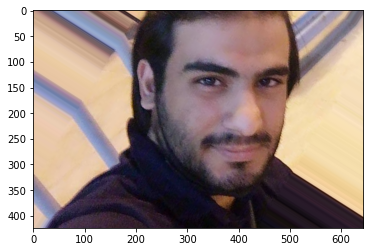

In [4]:
# Load the image
image_path = "/home/hassan-hossein/Desktop/dextop/folder_phaze_1/example_img.jpeg" # Change this to the path of your image
input_image = io.imread(image_path)

# Get the landmarks
landmarks = fa.get_landmarks(input_image)

if landmarks:
    # Use the first detected face's landmarks
    landmarks = landmarks[0]

    # Get the left and right eye coordinates
    left_eye = np.mean(landmarks[36:42], axis=0)
    right_eye = np.mean(landmarks[42:48], axis=0)

    # Calculate the angle to align the eyes horizontally
    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dy, dx))

    # Get the rotation matrix
    (h, w) = input_image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Rotate the image
    aligned_image = cv2.warpAffine(input_image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    plt.imshow(aligned_image)
    plt.show()
else:
    print("No faces detected.")
